In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os.path
from scipy.spatial.distance import cdist
import time
from tqdm import tqdm
%load_ext autoreload
%autoreload 1
#%aimport __pycache__.lddt.cpython-39
%aimport sautils.encoder_commons
%aimport sautils.common
import pandas as pd
import numba
from skopt import dump, load

In [2]:
sid2seq_ss = {}
with open('data/ss.fasta') as file:
    sid = ''
    for line in file:
        line = line.lstrip('>').rstrip('\n')
        if not sid:
            sid = line
        else:
            sid2seq_ss[sid] = line.upper()
            sid = ''
sid2seq_aa = {}
with open('data/aa.fasta') as file:
    sid = ''
    for line in file:
        line = line.lstrip('>').rstrip('\n')
        if not sid:
            sid = line
        else:
            sid2seq_aa[sid] = line.upper()
            sid = ''
mat3di = np.load('data/mat3di.npy') * 2.1
blosum = np.load('data/blosum62.npy') * 1.4
with open('data/mat3di.out') as f:
    lines = f.readlines()
i2a = lines[3].split()
def seq2num(q):
    idx = []
    for a in q:
        idx.append(i2a.index(a))
    return np.array(idx)
    
def calcS_np(ss1,ss2 ,aa1, aa2,mat3di, blosum):
    ss1 = seq2num(ss1)
    ss2 = seq2num(ss2)
    aa1 = seq2num(aa1)
    aa2 = seq2num(aa2)
    comb_array_ss = np.array(np.meshgrid(ss1, ss2)).T.reshape(-1, 2)
    comb_array_aa = np.array(np.meshgrid(aa1, aa2)).T.reshape(-1, 2)
    S = (mat3di[comb_array_ss[:,0],comb_array_ss[:,1]].reshape(len(ss1),-1)) + blosum[comb_array_aa[:,0],comb_array_aa[:,1]].reshape(len(aa1),-1)
    return S
def distances(q_points_aln, t_points_aln):
    d_mat = cdist(q_points_aln, t_points_aln)
    return (d_mat)

In [3]:
coord_dir = 'data/pdb/d*'
if not os.path.exists(coord_dir):
    print('Creating cache first.')
    sautils.encoder_commons.init_coords('data/pdb/d*', coord_dir)
sid2coords = {sid: sautils.encoder_commons.read_coords(coord_dir, sid) for sid in sautils.encoder_commons.list_sids(coord_dir)}

In [4]:
@numba.jit(nopython=True)
def fill_dp_matrix(scores, gap_open, gap_extend):
    l1, l2 = scores.shape
    s, q_gap, t_gap = np.zeros((l1+1, l2+1)), np.zeros((l1+1, l2+1)), np.zeros((l1+1, l2+1))
    for i in range(1, l1+1):
        for j in range(1, l2+1):
            q_gap[i, j] = max(q_gap[i, j-1] - gap_extend, s[i, j-1] - gap_open)
            t_gap[i, j] = max(t_gap[i-1, j] - gap_extend, s[i-1, j] - gap_open)
            s[i, j] = max(0,
                          q_gap[i, j],
                          t_gap[i, j],
                          s[i-1, j-1] + scores[i-1, j-1])
    return s, q_gap, t_gap

def backtrace_alignment(scores, gap_open, gap_extend, s, q_gap, t_gap):
    S_MAT, QGAP_MAT, TGAP_MAT = 0, 1, 2
    arg_max = np.where(s == s.max())
    i, j, pos = arg_max[0][0], arg_max[1][0], S_MAT
    backtrace = []
    while (s[i, j] > 0 or pos != S_MAT) and (i > 0 and j > 0):
        if pos == S_MAT:
            if s[i, j] == q_gap[i, j]:
                if q_gap[i,j] == q_gap[i, j-1] - gap_extend:
                    pos = QGAP_MAT
                j = j - 1       
            elif s[i, j] == t_gap[i, j]:
                if t_gap[i,j] == t_gap[i-1, j] - gap_extend:
                    pos = TGAP_MAT
                i = i - 1
            elif s[i,j] == s[i-1, j-1] + scores[i-1, j-1]:
                backtrace.append((i,j))
                i, j = i - 1, j - 1                
            else:
                break        
        elif pos == QGAP_MAT:
            if q_gap[i, j] == s[i, j-1] - gap_open:
                pos = S_MAT
            j = j - 1
            
        elif pos == TGAP_MAT:
            if t_gap[i, j] == s[i-1, j] - gap_open:
                pos = S_MAT
            i = i - 1
    return list(reversed([(i-1, j-1) for i, j in backtrace]))

def sw_align(scores, gap_open=30, gap_extend=10):    
    s, q_gap, t_gap = fill_dp_matrix(scores, gap_open, gap_extend)
    backtrace = backtrace_alignment(scores, gap_open, gap_extend, s, q_gap, t_gap)
    return backtrace, (s, q_gap, t_gap)

def format_aln(seq1, seq2, bt):
    s1, s2 = '', ''
    i_prev, j_prev = None, None
    for i, j in bt:        
        if i_prev is not None:
            s1 += seq1[i_prev+1:i] + '-' * len(seq2[j_prev+1:j])
            s2 += '-' * len(seq1[i_prev+1:i]) + seq2[j_prev+1:j]                
        s1 += seq1[i]
        s2 += seq2[j]
        i_prev, j_prev = i, j
    return s1, s2

In [5]:
def fb_local(S, go, ge, T, pre):
    S_exp = np.exp(S/T, dtype = pre)
    S_hat = S_exp[::-1,::-1]
    vj = np.exp(np.linspace((S.shape[1]-1)*ge + go, go, S.shape[1], dtype = pre)/T, dtype = pre)
    wj = np.exp(np.linspace((S.shape[1]-1)*ge , 0, S.shape[1], dtype = pre) /T, dtype = pre)
    zm, ze, zf = forward_backward_plain_local(S_exp, vj, wj, T, go, ge, pre)
    zm_hat, ze_hat, zf_hat = forward_backward_plain_local(S_hat, vj, wj, T, go, ge, pre)
    P = ((zm*(zm_hat[::-1,::-1]))/(1 + np.sum(zm))) * np.exp(-S/T, dtype = pre)
    return P
    
def fb_global(S, go, ge, T, pre):
    S_exp = np.exp(S/T, dtype = pre)
    S_hat = S_exp[::-1,::-1]

    vj = np.exp(np.linspace((S.shape[1]-1)*ge + go, go, S.shape[1])/T, dtype = pre)
    wj = np.exp(np.linspace((S.shape[1]-1)*ge , 0, S.shape[1]) /T, dtype = pre)
    zm, ze, zf = forward_backward_plain_global(S_exp, vj, wj, T, go, ge, pre)
    zm_hat, ze_hat, zf_hat = forward_backward_plain_global(S_hat, vj, wj, T, go, ge, pre)

    P = (zm*(zm_hat[::-1,::-1]))/ (zm[-1,-1]+ze[-1,-1] +zf[-1,-1]) * np.exp(-S/T, dtype = pre)
    
    return P
def fb_local_global(S, go, ge, T, pre):
    S_exp = np.exp(S/T, dtype = pre)
    S_hat = S_exp[::-1,::-1]

    vj = np.exp(np.linspace((S.shape[1]-1)*ge + go, go, S.shape[1])/T, dtype = pre)
    wj = np.exp(np.linspace((S.shape[1]-1)*ge , 0, S.shape[1]) /T, dtype = pre)
    zm, ze, zf = forward_backward_plain_local(S_exp, vj, wj, T, go, ge, pre)
    zm_hat, ze_hat, zf_hat = forward_backward_plain_global(S_hat, vj, wj, T, go, ge, pre)

    P = (zm*(zm_hat[::-1,::-1]))/ (zm[-1,-1]+ze[-1,-1] +zf[-1,-1])* np.exp(-S/T, dtype = pre)
    
    return P
    
def fb_global_local(S, go, ge, T, pre):
    S_exp = np.exp(S/T, dtype = pre)
    S_hat = S_exp[::-1,::-1]

    vj = np.exp(np.linspace((S.shape[1]-1)*ge + go, go, S.shape[1])/T, dtype = pre)
    wj = np.exp(np.linspace((S.shape[1]-1)*ge , 0, S.shape[1]) /T, dtype = pre)
    zm, ze, zf = forward_backward_plain_global(S_exp, vj, wj, T, go, ge, pre)
    zm_hat, ze_hat, zf_hat = forward_backward_plain_local(S_hat, vj, wj, T, go, ge, pre)

    P = (zm*(zm_hat[::-1,::-1]))/ np.sum(zm) * np.exp(-S/T)
    
    return P

In [6]:
def forward_backward_plain_local(S, vj, wj, T, go, ge, pre):
    exp_go = np.exp(go/T)
    exp_ge = np.exp(ge/T)
    zm = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    ze = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    zf = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    
    #This is the main part where we calculate the Z matrices with one for loop over each row
    for i in range(1,S.shape[0]+1):
        zm[i,1:] = ((zm[i-1,:-1] + ze[i-1,:-1] + zf[i-1,:-1] + 1) *S[i-1,:])
        # this is the new part where ze is calculated using cumsum 
        ze[i,1:] = (np.cumsum(zm[i,:-1] * vj)/wj) 
        zf[i,1:] = (zm[i-1,1:] * exp_go + zf[i-1,1:] * exp_ge)
    #at the end we only need to return zm but for testing i returned all
    return zm[1:,1:], ze[1:,1:], zf[1:,1:]

def forward_backward_plain_global(S, vj, wj, T, go, ge, pre):
    exp_go = np.exp(go/T)
    exp_ge = np.exp(ge/T)
    zm = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    ze = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    zf = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    
    zm[0,0] = 1
    ze[0,1:] = np.exp(np.linspace(go,go+(ge*(S.shape[1]-1)),S.shape[1])/T, dtype = pre)

    #exp_ge_arr = np.exp((np.arange(ge, (S.shape[1] + 1)* ge ,ge,dtype = pre))/T, dtype = pre)
                        
    for i in range(1,S.shape[0]+1):
        zm[i,1:] = (zm[i-1, :-1] + ze[i-1,:-1] + zf[i-1,:-1]) * S[i-1,:]
        ze[i,1:] = (np.cumsum(zm[i,:-1] * vj)/wj) #+  * exp_ge_arr
        zf[i,:] = zm[i-1,:] * exp_go + zf[i-1,:] * exp_ge
    return zm[1:,1:], ze[1:,1:], zf[1:,1:]

In [7]:
def forward_backward_plain_local(S, vj, wj, T, go, ge, pre):
    exp_go = np.exp(go/T)
    exp_ge = np.exp(ge/T)
    zm = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    ze = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    zf = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    
    #This is the main part where we calculate the Z matrices with one for loop over each row
    for i in range(1,S.shape[0]+1):
        zm[i,1:] = ((zm[i-1,:-1] + ze[i-1,:-1] + zf[i-1,:-1] + 1) *S[i-1,:])
        # this is the new part where ze is calculated using cumsum 
        ze[i,1:] = (np.cumsum(zm[i,:-1] * vj)/wj) 
        zf[i,1:] = (zm[i-1,1:] * exp_go + zf[i-1,1:] * exp_ge)
    #at the end we only need to return zm but for testing i returned all
    return zm[1:,1:], ze[1:,1:], zf[1:,1:]
def fb_local(S, go, ge, T, pre):
    S_exp = np.exp(S/T, dtype = pre)
    S_hat = S_exp[::-1,::-1]

    vj = np.exp(np.linspace((S.shape[1]-1)*ge + go, go, S.shape[1], dtype = pre)/T, dtype = pre)
    wj = np.exp(np.linspace((S.shape[1]-1)*ge , 0, S.shape[1], dtype = pre) /T, dtype = pre)
    #vj = np.exp(np.arange((S.shape[1]-1)*ge + go ,go-ge, -ge, dtype = pre)/T)
    #wj = np.exp((np.arange((S.shape[1]-1)*ge , -ge, -ge, dtype = pre)) /T)
    zm, ze, zf = forward_backward_plain_local(S_exp, vj, wj, T, go, ge, pre)
    zm_hat, ze_hat, zf_hat = forward_backward_plain_local(S_hat, vj, wj, T, go, ge, pre)

    P = ((zm*(zm_hat[::-1,::-1]))/(1 + np.sum(zm))) * np.exp(-S/T, dtype = pre)
    
    return P

In [8]:
@numba.njit
def lol_score_approx(d_ij, d_kl, d_seq):
    seq_distance_feat = np.sign(d_seq) * np.log(1 + np.abs(d_seq))
    x = np.empty((d_ij.shape[0],2))
    x[:,0] = seq_distance_feat#[:, None]
    x[:,1] = np.abs(d_ij-d_kl)#[:, None]
    #x = np.hstack([seq_distance_feat[:, None], np.abs(d_ij-d_kl)[:, None],])

    w1 = np.array([[-1.3584513e-04,  9.9329501e-01],
                   [ 7.6149112e-01,  5.7029408e-01],
                   [-8.1348085e-01,  6.0702705e-01]])
    b1 = np.array([0.7043129 , 0.374659  , 0.39905924])
    w2 = np.array([[-0.776632  ,  0.61055756,  0.5823986 ]])
    b2 = np.array([-0.11200039])

    hidden_layer = ((x @ w1.T) + b1)
    hidden_layer *= (hidden_layer > 0)  # if w1 is all positive, we dont need this ReLU
    score = (hidden_layer @ w2.T) + b2
    return score

In [9]:
def calc_startAnchors(S, fb_go, fb_ge, temp, le):
    start_anchors = []
    for i in range(10):
        P = fb_local(S, fb_go, fb_ge, temp, np.longdouble)
        x,y = np.unravel_index(np.argmax(P), P.shape)
        x,y = np.max([0,x-le]), np.max([0,y-le])
        #P -= np.max([0 ,np.max(P)-shift])
        bt, (s, q_gap, t_gap) = sw_align(np.array(P[x:x+(le*2),y:y+(le*2)], dtype = np.double), gap_open = 0, gap_extend=0)
        bt = np.array(bt)
        bt[:,0] += x
        bt[:,1] += y
        start_anchors.append(np.copy(bt))
        S[bt[:,0], bt[:,1]] = - 100
    return start_anchors

In [10]:
def get_gaps(A_all):
    lowerBounds_i = (A_all[:,0]+1)[:-1]
    upperBounds_i = (A_all[:,0]-1)[1:]
    lowerBounds_k = (A_all[:,1]+1)[:-1]
    upperBounds_k = (A_all[:,1]-1)[1:]
    mask_i = lowerBounds_i<=upperBounds_i
    mask_k = lowerBounds_k<=upperBounds_k
    mask = np.logical_and(mask_i,  mask_k)
    return np.array([np.sort(np.array([lowerBounds_i[mask],upperBounds_i[mask]+1]).reshape(-1)),
                    np.sort(np.array([lowerBounds_k[mask],upperBounds_k[mask]+1]).reshape(-1))])

In [11]:

def lol_matrix_gap_dist_aprox(A, All_a, gaps,d_mat_ij, d_mat_kl):

    ti, tk, tidx = lol_matrix_prep_gaps(A, All_a, gaps, d_mat_ij, d_mat_kl)
    idx = np.logical_and(ti > 0, tk > 0)
    G_mat = np.zeros_like(ti)
    G_mat[idx] += np.squeeze(np.nan_to_num(lol_score_approx(ti[idx], tk[idx], tidx[idx])))
    return G_mat.reshape(gaps[0,1]-gaps[0,0], gaps[1,1]-gaps[1,0], -1).sum(axis=2)

In [12]:
def lol_matrix_prep_gaps(A, All_a, gaps,d_mat_ij, d_mat_kl):
    #print(d_mat_ij[:,gaps[0,0]:gaps[0,1]].shape, d_mat_kl[:,gaps[1,0]:gaps[1,1]].shape)
    d_ij, d_kl = np.array(d_mat_ij[A[:,0],gaps[0,0]:gaps[0,1]]), np.array(d_mat_kl[A[:,1],gaps[1,0]:gaps[1,1]])
    ti = np.repeat(d_ij.T, gaps[1,1] - gaps[1,0], axis = 0).reshape(-1)
    tk = np.repeat(d_kl.T.reshape(-1,1), gaps[0,1]-gaps[0,0], axis = 1).T.reshape(-1)
    tidx = np.repeat(A[:,0].reshape(1,-1), d_ij.shape[1] * d_kl.shape[1], axis = 0).reshape(-1)
    #print(ti.shape, tk.shape, tidx.shape, np.repeat(np.arange(gaps[0,0],gaps[0,1]), (gaps[1,1]-gaps[1,0]) * A.shape[0]).shape)
    tidx = tidx - np.repeat(np.arange(gaps[0,0],gaps[0,1]), (gaps[1,1]-gaps[1,0]) * A.shape[0])

    return ti, tk, tidx

In [13]:
def align(S, startAnchors, go, ge, min_m, red_m, temp, red_t, d_mat_ij, d_mat_kl):
    S_all = []
    ap_all = []
    pre = np.longdouble
    lol_matrix_prep = lol_matrix_prep_gaps
    for j in range(10):
        num_all = 0
        th = .99
        tempr = temp
        S = np.zeros_like(S, dtype = pre)
        A_new = startAnchors[j]
        A_all = startAnchors[j]

        for i in (range(1000)):
            #S[A_all[:,0], A_all[:,1]] = 1e2
            gaps_idn = get_gaps(np.unique(np.concatenate((np.array([-1,-1]).reshape(1,2), A_all, np.array([S.shape[0], S.shape[1]]).reshape(1,2))), axis = 0))
            P = np.zeros_like(S)
            
            for g in range(0, gaps_idn.shape[1], 2):
                S[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]] += lol_matrix_gap_dist_aprox(A_new, A_all, gaps_idn[:,g:g+2] ,d_mat_ij, d_mat_kl)
            #S += lol_matrix_gap_dist_aprox(A_new, A_all, np.array([[0,0],[S.shape[0], S.shape[1]]]).T ,d_mat_ij, d_mat_kl)
            for g in range(0, gaps_idn.shape[1], 2):
                P[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]] = fb_global(S[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]], go, ge, tempr, pre)
                if (g == 0 and gaps_idn[0,g] == 0 and gaps_idn[1,g] == 0):
                    P[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]] = fb_local_global(S[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]], go, ge, tempr, pre)
                elif(g == (gaps_idn.shape[1]-2), gaps_idn[0,g+1] == S.shape[0], gaps_idn[1,g+1] == S.shape[1]):
                    P[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]] = fb_local_global(S[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]], go, ge, tempr, pre)
                    
                else:
                    P[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]] = fb_global(S[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]], go, ge, tempr, pre)
                    

            m = np.max(P)
            if m <= min_m:
                break
            A_new = np.argwhere(P >= np.max([m - red_m, min_m]))
            A_all = np.vstack((A_all, A_new))
            A_all = np.sort(A_all, axis = 0)
            #num_all -= 1
            #tempr = np.max([tempr-red_t, 1])
        #S[A_all[:,0], A_all[:,1]] = 1e2
        S_all.append(np.copy(S))
        ap_all.append(np.copy(A_all))
    return S_all, ap_all

In [14]:
class lol_alignment():
    def __init__(self, sa_fb_go=-3, sa_fb_ge=-2, sa_temp = 1, le = 3,
                 lol_go=-3, lol_ge=0, lol_min_m=0.4,  lol_red_t = 0, lol_temp=2):
        self.sa_fb_go = sa_fb_go
        self.sa_fb_ge = sa_fb_ge
        self.sa_temp = sa_temp
        self.le = le
        self.lol_go = lol_go
        self.lol_ge = lol_ge 
        self.lol_min_m = lol_min_m
        self.lol_red_m = 0.1
        self.lol_red_t = lol_red_t
        self.lol_temp = lol_temp
        self.alignments = {}
        self.start_time = time.time()

    def fit(self, querys, targets,*kwargs):
        for query,target in tqdm(zip(querys, targets), total = querys.shape[0]):
            if query == target:
                print(query,target)
            else:
                coords1,_ = sid2coords.get(query)
                coords2,_ = sid2coords.get(target)
                coords1 = coords1[:,:3]
                coords2 = coords2[:,:3]
                d_mat_ij = distances(coords1, coords1)
                d_mat_ij[d_mat_ij > 15] = 0
                d_mat_kl = distances(coords2, coords2)
                d_mat_ij = np.asarray(d_mat_ij)
                d_mat_kl = np.asarray(d_mat_kl)
                aa1 = sid2seq_aa[query]
                aa2 = sid2seq_aa[target]
                ss1 = sid2seq_ss[query]
                ss2 = sid2seq_ss[target]
                S = calcS_np(ss1, ss2, aa1, aa2, mat3di, blosum)




                startAnchors = calc_startAnchors(S, self.sa_fb_go, self.sa_fb_ge, self.sa_temp, self.le)
                S_lols, aps = align(S, startAnchors, self.lol_go, self.lol_ge, self.lol_min_m,
                                                        self.lol_red_m, self.lol_temp, self.lol_red_t, d_mat_ij, d_mat_kl)
                #self.alignments[query+"_"+target] = align(S, startAnchors, self.lol_go, self.lol_ge, self.lol_min_m,
                #                                       self.lol_red_m, self.lol_temp, self.lol_red_t, d_mat_ij, d_mat_kl)
                ap = []
                #print(time.time() - st, S.shape[0], S.shape[1])
                for i in range(10):
                    S_lol, ap = S_lols[i], aps[i]
                    self.alignments[query+"_"+target + str(i)] = np.copy(ap)
                #rescale_scores.append(((S+S_lol) * fb_local(S +S_lol, -3.5, -.3, 2, np.longdouble)).sum() / np.sqrt(S.shape[0]*S.shape[1]))
                #di_scores.append(((S+S_lol) * fb_local(S +S_lol, -30, -10, 15, np.longdouble)).sum())
                
            #self.rescale_score[query+"_"+target] = np.max(rescale_scores)
            #self.di_score[query+"_"+target] = np.max(di_scores)
            #print(time.time() - st, S.shape[0], S.shape[1])
            


In [15]:
sens_alig = lol_alignment()

In [19]:
sens_alig.fit(query,target)

  3%|███                                                                                                         | 28/1000 [00:47<25:47,  1.59s/it]

d1o89a2 d1o89a2


  3%|███▌                                                                                                        | 33/1000 [00:56<25:00,  1.55s/it]

d3lg3a_ d3lg3a_


  4%|████▎                                                                                                       | 40/1000 [01:01<13:19,  1.20it/s]

d1a6qa1 d1a6qa1


  5%|█████▌                                                                                                      | 52/1000 [01:17<24:31,  1.55s/it]

d1xa6a2 d1xa6a2


 13%|█████████████▌                                                                                             | 127/1000 [03:22<25:17,  1.74s/it]

d1jb7b_ d1jb7b_


 15%|████████████████▎                                                                                          | 153/1000 [03:56<12:26,  1.13it/s]

d2dida1 d2dida1


 22%|███████████████████████▊                                                                                   | 223/1000 [05:48<33:02,  2.55s/it]

d1qw9a1 d1qw9a1
d2w0pa_ d2w0pa_


 25%|███████████████████████████▏                                                                               | 254/1000 [06:39<23:16,  1.87s/it]

d1fc6a3 d1fc6a3


 26%|████████████████████████████▎                                                                              | 265/1000 [06:57<22:58,  1.87s/it]

d3d85d1 d3d85d1


 31%|█████████████████████████████████                                                                          | 309/1000 [08:25<14:30,  1.26s/it]

d1iura_ d1iura_


 32%|█████████████████████████████████▉                                                                         | 317/1000 [08:33<16:10,  1.42s/it]

d3ah7a_ d3ah7a_


 32%|██████████████████████████████████▏                                                                        | 319/1000 [08:34<10:15,  1.11it/s]

d1ayea2 d1ayea2


 35%|█████████████████████████████████████▉                                                                     | 354/1000 [09:55<25:27,  2.36s/it]

d1m8pa3 d1m8pa3


 37%|███████████████████████████████████████▍                                                                   | 368/1000 [10:15<14:48,  1.41s/it]

d1qlwa_ d1qlwa_


 41%|███████████████████████████████████████████▉                                                               | 411/1000 [11:57<21:02,  2.14s/it]

d1e1oa1 d1e1oa1


 44%|███████████████████████████████████████████████▏                                                           | 441/1000 [12:58<21:22,  2.29s/it]

d1awcb_ d1awcb_


 49%|████████████████████████████████████████████████████▊                                                      | 494/1000 [14:25<11:23,  1.35s/it]

d2gz4a1 d2gz4a1


 50%|█████████████████████████████████████████████████████▍                                                     | 499/1000 [14:31<11:27,  1.37s/it]

d1nu9c1 d1nu9c1


 52%|████████████████████████████████████████████████████████                                                   | 524/1000 [14:56<07:02,  1.13it/s]

d2f02a_ d2f02a_


 54%|█████████████████████████████████████████████████████████▌                                                 | 538/1000 [15:30<14:41,  1.91s/it]

d1sbxa_ d1sbxa_


 55%|██████████████████████████████████████████████████████████▍                                                | 546/1000 [15:42<12:53,  1.70s/it]

d3er9b_ d3er9b_


 57%|████████████████████████████████████████████████████████████▉                                              | 570/1000 [16:17<14:18,  2.00s/it]

d1nu9c2 d1nu9c2


 58%|██████████████████████████████████████████████████████████████▌                                            | 585/1000 [16:41<07:51,  1.14s/it]

d1x5ga1 d1x5ga1


 59%|███████████████████████████████████████████████████████████████▎                                           | 592/1000 [16:54<13:24,  1.97s/it]

d2ek1a_ d2ek1a_


 62%|██████████████████████████████████████████████████████████████████▍                                        | 621/1000 [17:44<12:16,  1.94s/it]

d2p6va1 d2p6va1


 64%|████████████████████████████████████████████████████████████████████▋                                      | 642/1000 [18:10<08:33,  1.43s/it]

d2hkja2 d2hkja2


 65%|█████████████████████████████████████████████████████████████████████▎                                     | 648/1000 [18:17<07:29,  1.28s/it]

d1tc1a_ d1tc1a_


 67%|███████████████████████████████████████████████████████████████████████▌                                   | 669/1000 [18:45<05:22,  1.03it/s]

d1v8ca2 d1v8ca2


 69%|█████████████████████████████████████████████████████████████████████████▌                                 | 688/1000 [19:12<02:57,  1.76it/s]

d1txoa_ d1txoa_


 69%|█████████████████████████████████████████████████████████████████████████▊                                 | 690/1000 [19:13<02:52,  1.79it/s]

d256ba_ d256ba_


 70%|███████████████████████████████████████████████████████████████████████████                                | 701/1000 [19:39<08:37,  1.73s/it]

d1qb7a_ d1qb7a_


 73%|██████████████████████████████████████████████████████████████████████████████▍                            | 733/1000 [20:17<07:52,  1.77s/it]

d1lmb3_ d1lmb3_


 78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 781/1000 [21:22<04:09,  1.14s/it]

d1wgxa_ d1wgxa_


 78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 785/1000 [21:28<04:35,  1.28s/it]

d1yovb_ d1yovb_


 80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 800/1000 [21:52<05:16,  1.58s/it]

d2dmya1 d2dmya1


 82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 816/1000 [22:15<03:36,  1.17s/it]

d1lg7a_ d1lg7a_


 84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 842/1000 [22:55<03:08,  1.19s/it]

d2cchb1 d2cchb1


 87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 870/1000 [23:54<07:05,  3.27s/it]

d2gz1a2 d2gz1a2


 88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 878/1000 [24:02<02:43,  1.34s/it]

d1urha1 d1urha1


 88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 881/1000 [24:05<02:21,  1.19s/it]

d2dx6a_ d2dx6a_


 89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 891/1000 [24:22<03:03,  1.69s/it]

d2azna1 d2azna1


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 907/1000 [24:43<02:20,  1.51s/it]

d2absa1 d2absa1


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 933/1000 [25:14<01:08,  1.02s/it]

d1q6za3 d1q6za3


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 939/1000 [25:20<00:59,  1.02it/s]

d1h2sb_ d1h2sb_


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 946/1000 [25:30<01:42,  1.90s/it]

d1vq831 d1vq831


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████   | 972/1000 [26:06<00:36,  1.29s/it]

d1ix9a1 d1ix9a1


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 993/1000 [26:37<00:08,  1.22s/it]

d2uy6b1 d2uy6b1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [26:42<00:00,  1.60s/it]

d2hv2a1 d2hv2a1


In [140]:
(query==target).sum()

49

In [16]:
alignments = pd.read_csv("benchmark/alignments.csv", sep='\,')


/tmp/ipykernel_27465/2090322524.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  alignments = pd.read_csv("benchmark/alignments.csv", sep='\,')


In [17]:
sample = alignments[(alignments["same_sfam"] == True)].sample(1000, random_state=42)

In [18]:
query, target = sample['query'].values, sample['target'].values

In [20]:
sens_alig.alignments

{}

('d2z5ka_', 'd2z5ka_')

In [20]:
def calc_score_dali(ap, d_mat_ij, d_mat_kl):
    lol_score =  0
    pre = np.longdouble
    index_test = (ap[:,0]).reshape(-1)[None,:] - ap[:,1][:,None]
    d_mat_ij_test = d_mat_ij[:, ap[:,0]]
    d_mat_ij_test = d_mat_ij_test[ap[:,0], :]
    d_mat_kl_test = d_mat_kl[:,ap[:,1]]
    d_mat_kl_test = d_mat_kl_test[ap[:,1], :]
    d_mask_test = d_mat_ij_test > 0
    d_ij_test, d_kl_test, d_seq_test = d_mat_ij_test[d_mask_test], d_mat_kl_test[d_mask_test], index_test[d_mask_test]
    _lol_scores = lol_score_approx(d_ij_test, d_kl_test, d_seq_test)
    
    return np.sum(_lol_scores)

In [21]:
def calc_score(aps, d_mat_ij, d_mat_kl):
    lol_score =  0
    pre = np.longdouble
    
    all_lolscores = np.zeros(10)

    for i in range(10):
        ap = aps[i]

        index_test = (ap[:,0]).reshape(-1)[None,:] - ap[:,1][:,None]
        d_mat_ij_test = d_mat_ij[:, ap[:,0]]
        d_mat_ij_test = d_mat_ij_test[ap[:,0], :]
        d_mat_kl_test = d_mat_kl[:,ap[:,1]]
        d_mat_kl_test = d_mat_kl_test[ap[:,1], :]
        d_mask_test = d_mat_ij_test > 0
        

        d_ij_test, d_kl_test, d_seq_test = d_mat_ij_test[d_mask_test], d_mat_kl_test[d_mask_test], index_test[d_mask_test]
        _lol_scores = lol_score_approx(d_ij_test, d_kl_test, d_seq_test)
        all_lolscores[i] = np.sum(_lol_scores)
    return np.max(all_lolscores)

In [131]:
sample

,query,target,bits,lddt,cigar_fs,qstart_fs,tstart_fs,alnlen,q_scope,t_scope,same_fam,same_sfam,same_fold,qstart_dali,tstart_dali,cigar_dali,dali_rank
301063,d2ptfa1,d1i0ra_,166,0.4954,9M3I19M3D36M3D7M5D5M3I3M4D8M2D19M6I20M1I11M,7,1,167,b.45.1.4,b.45.1.2,False,True,True,9,1,21M1I9M1D6M2D28M3D12M6D11M1D7M1D16M6I24M2D7M40I4M,9
325597,d3bmva1,d1imhc1,110,0.6479,10M2D14M2I3M1D6M9D6M2D13M6D15M1I2M1D4M,4,2,97,b.1.18.2,b.1.18.1,False,True,True,3,1,13M2D13M1I8M9D8M2D14M6D12M1I11M,3
264156,d2g17a2,d1vm6a2,29,0.3671,14M4I4M1D9M3I6M16I19M1D6M2I7M,3,6,92,d.81.1.1,d.81.1.3,False,True,True,1,4,15M1I5M2I13M19I27M1I11M48I12M,16
200578,d1xera_,d2c42a5,55,0.5075,24M17D16M1D20M2D6M,37,13,86,d.58.1.3,d.58.1.5,False,True,True,25,1,40M15D5M4D8M1I17M2D8M,12
66707,d1jhja_,d2vnga1,78,0.3749,7M4D2M9D7M1D3M7D3M1I6M3D23M1I10M1D3M4D5M1D7M3I...,20,2,176,b.18.1.9,b.18.1.33,False,True,True,21,1,5M1D5M1D4M3D9M8D7M13D5M1I11M1I13M6D17M5I8M8D13...,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188345,d1wfna1,d1x3da1,236,0.6435,64M1I30M1D8M,1,1,104,b.1.2.1,b.1.2.1,True,True,True,1,1,34M1I4M1D10M1D5M1I4M1D4M2I31M1D9M,35
295220,d2ouxa2,d1pvma4,175,0.7099,31M5I23M6D5M1D55M,1,3,126,d.37.1.1,d.37.1.1,True,True,True,1,3,31M5I24M7D64M11D3M,18
49940,d1hbxg_,d1mzba_,20,0.4787,6M1D9M3I2M12I15M1I28M2D8M19D20M,4,14,126,a.4.5.21,a.4.5.42,False,True,True,1,16,14M16I4M2I14M2I24M2D12M24D24M,31
191465,d1wk1a_,d1qdda_,170,0.6092,11M4D19M1D19M5D11M1D14M7I25M2I18M,2,13,137,d.169.1.1,d.169.1.1,True,True,True,1,7,4M9D26M1D21M5D12M1D8M5I6M2I24M2I21M,16


In [22]:
lol_fs = []
for q,t,qstart,tstart,cigar in zip(sample['query'].values, sample['target'].values, sample['qstart_fs'].values, sample['tstart_fs'].values, sample['cigar_fs'].values):
    if q != t:
        coords1, mask1 = sid2coords.get(q)
        coords2, mask2 = sid2coords.get(t) 
        coords1 = coords1[:,:3]
        coords2 = coords2[:,:3]
        d_mat_ij = distances(coords1, coords1)
        d_mat_ij[d_mat_ij > 15] = 0
        d_mat_kl = distances(coords2, coords2)
        
   
        (aln_coords1, aln_coords2), (idx1, idx2), (len1, len2) =\
                align_coords((coords1, mask1),
                             (coords2, mask2),
                             (cigar, qstart, tstart))
        lol_fs.append(calc_score_dali(np.array([idx1, idx2]).T, d_mat_ij, d_mat_kl))

NameError: name 'align_coords' is not defined

In [23]:
lol_dali = []

lol_new = []
for q,t,qstart,tstart,cigar in zip(sample['query'].values, sample['target'].values, sample['qstart_dali'].values, sample['tstart_dali'].values, sample['cigar_dali'].values):
    if q != t:
        coords1, mask1 = sid2coords.get(q)
        coords2, mask2 = sid2coords.get(t) 
        coords1 = coords1[:,:3]
        coords2 = coords2[:,:3]
        d_mat_ij = distances(coords1, coords1)
        d_mat_ij[d_mat_ij > 15] = 0
        d_mat_kl = distances(coords2, coords2)
        
   
        (aln_coords1, aln_coords2), (idx1, idx2), (len1, len2) =\
                align_coords((coords1, mask1),
                             (coords2, mask2),
                             (cigar, qstart, tstart))
        lol_dali.append(calc_score_dali(np.array([idx1, idx2]).T, d_mat_ij, d_mat_kl))


        
        aps_lol =[]
        for i in range(10):
            aps_lol.append(sens_alig.alignments[q+"_"+t + str(i)])
        lol_new.append(calc_score(aps_lol, d_mat_ij, d_mat_kl))
    

NameError: name 'align_coords' is not defined

In [153]:
(np.array(lol_dali) - np.array(lol_new)).mean()

-296.6936190390235

Text(0.5, 0, 'Dali LoL-Score - Prosa LoL-Score')

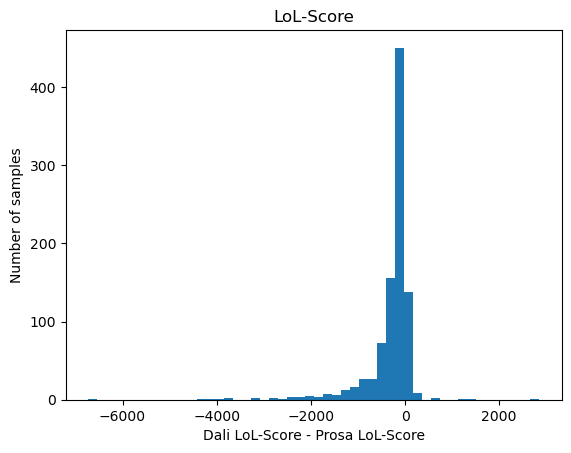

In [39]:
plt.hist(np.array(lol_dali) - np.array(lol_new), bins = 50)
plt.title('LoL-Score')
plt.ylabel('Number of samples')
plt.xlabel('Dali LoL-Score - Prosa LoL-Score')

Text(0.5, 0, 'Foldseek LoL-Score - Prosa LoL-Score')

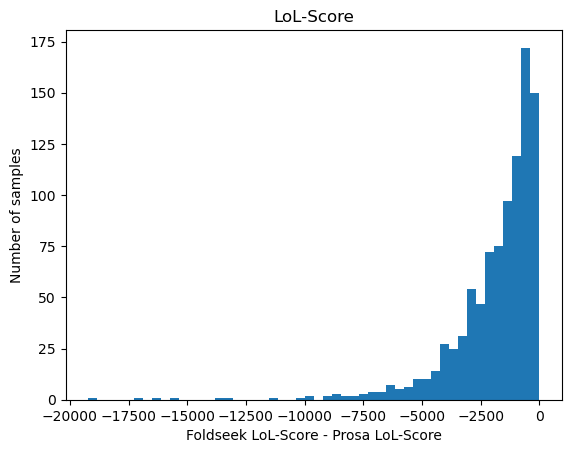

In [40]:
plt.hist(np.array(lol_fs) - np.array(lol_new), bins = 50)
plt.title('LoL-Score')
plt.ylabel('Number of samples')
plt.xlabel('Foldseek LoL-Score - Prosa LoL-Score')

In [92]:
sample

,query,target,bits,lddt,cigar_fs,qstart_fs,tstart_fs,alnlen,q_scope,t_scope,same_fam,same_sfam,same_fold,qstart_dali,tstart_dali,cigar_dali,dali_rank
301063,d2ptfa1,d1i0ra_,166,0.4954,9M3I19M3D36M3D7M5D5M3I3M4D8M2D19M6I20M1I11M,7,1,167,b.45.1.4,b.45.1.2,False,True,True,9,1,21M1I9M1D6M2D28M3D12M6D11M1D7M1D16M6I24M2D7M40I4M,9
325597,d3bmva1,d1imhc1,110,0.6479,10M2D14M2I3M1D6M9D6M2D13M6D15M1I2M1D4M,4,2,97,b.1.18.2,b.1.18.1,False,True,True,3,1,13M2D13M1I8M9D8M2D14M6D12M1I11M,3
264156,d2g17a2,d1vm6a2,29,0.3671,14M4I4M1D9M3I6M16I19M1D6M2I7M,3,6,92,d.81.1.1,d.81.1.3,False,True,True,1,4,15M1I5M2I13M19I27M1I11M48I12M,16
200578,d1xera_,d2c42a5,55,0.5075,24M17D16M1D20M2D6M,37,13,86,d.58.1.3,d.58.1.5,False,True,True,25,1,40M15D5M4D8M1I17M2D8M,12
66707,d1jhja_,d2vnga1,78,0.3749,7M4D2M9D7M1D3M7D3M1I6M3D23M1I10M1D3M4D5M1D7M3I...,20,2,176,b.18.1.9,b.18.1.33,False,True,True,21,1,5M1D5M1D4M3D9M8D7M13D5M1I11M1I13M6D17M5I8M8D13...,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188345,d1wfna1,d1x3da1,236,0.6435,64M1I30M1D8M,1,1,104,b.1.2.1,b.1.2.1,True,True,True,1,1,34M1I4M1D10M1D5M1I4M1D4M2I31M1D9M,35
295220,d2ouxa2,d1pvma4,175,0.7099,31M5I23M6D5M1D55M,1,3,126,d.37.1.1,d.37.1.1,True,True,True,1,3,31M5I24M7D64M11D3M,18
49940,d1hbxg_,d1mzba_,20,0.4787,6M1D9M3I2M12I15M1I28M2D8M19D20M,4,14,126,a.4.5.21,a.4.5.42,False,True,True,1,16,14M16I4M2I14M2I24M2D12M24D24M,31
191465,d1wk1a_,d1qdda_,170,0.6092,11M4D19M1D19M5D11M1D14M7I25M2I18M,2,13,137,d.169.1.1,d.169.1.1,True,True,True,1,7,4M9D26M1D21M5D12M1D8M5I6M2I24M2I21M,16


In [24]:
def lddt_multidomain_new(d_ij, d_kl, d_mn, idx1, cutoff):
    d = np.abs(d_kl - d_ij)

    score = 0.25 * ((d < 0.5).astype(np.float32) +
                    (d < 1.0).astype(np.float32) +
                    (d < 2.0).astype(np.float32) +
                    (d < 4.0).astype(np.float32))

    # Note: 0 is used to masked distances
    neighbor_mask = ((0 < d_ij) & (d_ij < cutoff)).astype(np.float32) * (1. - np.eye(len(d_ij)))
 
    score_per_residue = np.sum(neighbor_mask * score, axis=-1)
    norm_per_residue = np.sum((0 < d_mn) & (d_mn < cutoff), axis=-1)[idx1]

    return np.mean(score_per_residue / norm_per_residue), (neighbor_mask * score, norm_per_residue)

# From distance matrix to alignment score
def lddt_score_new(aln, load_coords_fn, AL):
    d_mat_ij, d_mat_kl, d_mn, idx1 = aligned_distance_mats_new(aln, load_coords_fn, AL)
    return lddt_multidomain_new(d_mat_ij, d_mat_kl, d_mn, idx1, 15)
def aligned_distance_mats_new(aln, load_coords_fn, AL, th=.51):
    coords1,mask1 = sid2coords.get(aln['query'])
    coords2,mask2 = sid2coords.get(aln['target'])
    d_mat_ij = distances(coords1[:,:3], coords1[:,:3])
    d_mat_ij[d_mat_ij > 15] = 0
    d_mat_kl = distances(coords2[:,:3], coords2[:,:3])
    
    al = AL
    
    idx1 = np.arange(d_mat_ij.shape[0])
        
    #index_temp = np.argwhere(np.sum(AL > 1e2,axis = 1) == 0)

    idx1 = idx1[al[:,0]]
    
    
    d_mat_ij_test = d_mat_ij[:, al[:,0]]
    d_mat_ij_test = d_mat_ij_test[al[:,0], :]
    d_mat_kl_test = d_mat_kl[:,al[:,1]]
    d_mat_kl_test = d_mat_kl_test[al[:,1], :]
    
    

    # sequence distance between *aligned* query residues
    d_mat_mn = distances_mn(coords1[:, 0:3], mask1)  # intra-molecular distances between *all* query residues
    return d_mat_ij_test, d_mat_kl_test, d_mat_mn, idx1

def align_coords(query, target, alignment):
    coords1, mask1 = query
    coords2, mask2 = target
    cigar, q_start, t_start = alignment

    idx1, idx2 = sautils.common.parse_cigar(cigar, query=q_start, ref=t_start, include_m=True, order_qt=True).T

    # Remove masked residues from alignment
    mask = mask1[idx1] & mask2[idx2]
    aln_coords1 = coords1[idx1, :3][mask]  # need only CA
    aln_coords2 = coords2[idx2, :3][mask]    
    return (aln_coords1, aln_coords2), (idx1, idx2), (len(coords1), len(coords2))
def distances_ij(q_points_aln, t_points_aln, cutoff=15):
    """intra-molecular distances with cutoff"""
    d_ij = np.sqrt(np.sum((q_points_aln[:, None] - q_points_aln[None, :])**2, axis=-1))
    d_kl = np.sqrt(np.sum((t_points_aln[:, None] - t_points_aln[None, :])**2, axis=-1))

    neighbor_mask = (d_ij < cutoff).astype(np.float32) * (1. - np.eye(len(d_ij)))
    return (neighbor_mask * d_ij, neighbor_mask * d_kl)

def distances_mn(coords, mask):
    """Intra-molecular distances between all residues.
       Residue coords can be NaN.
    """
    d_mn = np.sqrt(np.sum((coords[:, None] - coords[None, :])**2, axis=-1))
    d_mn[~mask, :] = 0
    d_mn[:, ~mask] = 0
    return d_mn

In [25]:
ite = -1
all_lddt_dali = np.zeros([1,1000])
for q,t,qstart,tstart,cigar in zip(sample['query'].values, sample['target'].values, sample['qstart_dali'].values, sample['tstart_dali'].values, sample['cigar_dali'].values):
    ite += 1
    example_alignment = {'query': q,
                     'target': t}
    
    coords1, mask1 = sid2coords.get(q)
    coords2, mask2 = sid2coords.get(t)    
    (aln_coords1, aln_coords2), (idx1, idx2), (len1, len2) =\
            align_coords((coords1, mask1),
                         (coords2, mask2),
                         (cigar, qstart, tstart))
    for j in range(1):
        #P = fb_local(S, go, ge, 5, pre)
        #lddt_lol.append(lddt_score_new(example_alignment, sid2coords.get, P)[0])
        if q == t:
            all_lddt_dali[:,ite] = 1
            #break
        all_lddt_dali[j,ite] = lddt_score_new(example_alignment, sid2coords.get, np.array([idx1,idx2]).T)[0]
        

In [26]:
i = -1
all_lddt_init = np.zeros([10,1000])
for q,t in zip(sample['query'].values, sample['target'].values):
    i += 1
    example_alignment = {'query': q,
                     'target': t}
    for j in range(10):
        
        #P = fb_local(S, go, ge, 5, pre)
        #lddt_lol.append(lddt_score_new(example_alignment, sid2coords.get, P)[0])
        if q == t:
            all_lddt_init[:,i] = 1
            break
            
        all_lddt_init[j,i] = lddt_score_new(example_alignment, sid2coords.get, sens_alig.alignments[q+"_"+t + str(j)])[0]
        
    #print(q,t,lddt_dali[i], lddt_lol[i])

Text(0, 0.5, 'LDDT score Prosa')

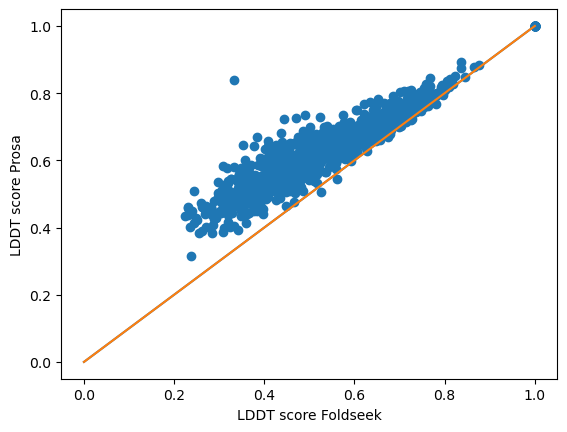

In [27]:
plt.scatter(sample["lddt"].values, np.max(all_lddt_init, axis = 0))
plt.plot([[0,0],[1,1]])
plt.xlabel('LDDT score Foldseek')
plt.ylabel('LDDT score Prosa')


Text(0, 0.5, 'LDDT score Prosa')

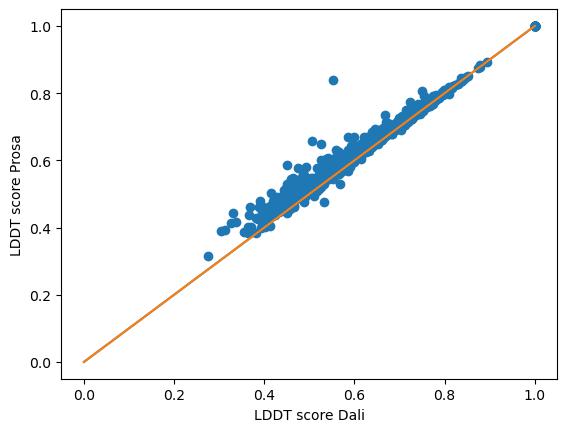

In [28]:
plt.scatter(np.max(all_lddt_dali, axis = 0), np.max(all_lddt_init, axis = 0))
plt.plot([[0,0],[1,1]])
#plt.title("LDDT-Score")
plt.xlabel('LDDT score Dali')
plt.ylabel('LDDT score Prosa')

In [157]:
(np.max(all_lddt_dali, axis = 0) - np.max(all_lddt_init, axis = 0)).mean()

-0.018105929988675128

Text(0, 0.5, 'New alignments')

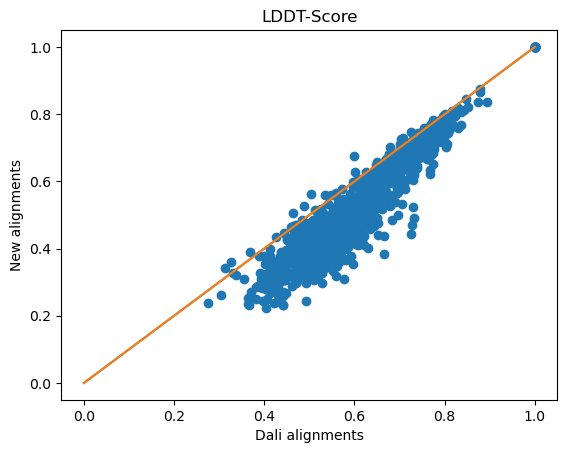

In [130]:
plt.scatter(np.max(all_lddt_dali, axis = 0), sample["lddt"].values)
plt.plot([[0,0],[1,1]])
#plt.title("LDDT-Score")
plt.xlabel('Dali alignments')
plt.ylabel('New alignments')